# DeepQNetwork
> by Khizr Ali Pardhan | Alik604


### done
* Steal some samplecode
    - why reimplement the wheel? 
    
    
### todo 

* gym -> luner lander 
* gym addon -> robot
    - https://github.com/nplan/gym-line-follower 
    - https://github.com/jr-robotics/robo-gym 

* try D4PG
    - new notebook?

more todo
```
https://www.youtube.com/watch?v=H9uCYnG3LlE
https://www.youtube.com/watch?v=2vJtbAha3To
https://www.youtube.com/watch?v=hlv79rcHws0
```

In [1]:
import utils 

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import gym

In [5]:
# from https://raw.githubusercontent.com/philtabor/Youtube-Code-Repository/master/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

In [6]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=128, fc2_dims=128)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=64)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min

        #if self.iter_cntr % self.replace_target == 0:
        #   self.Q_next.load_state_dict(self.Q_eval.state_dict())

In [9]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=128, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.001, eps_dec=5e-4/2) # changed from eps_dec=5e-4

scores, eps_history = [], []
n_games = 200

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])

    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)
x = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'

episode  0 score -110.54 average score -110.54 epsilon 1.00
episode  1 score -186.72 average score -148.63 epsilon 1.00
episode  2 score -313.48 average score -203.58 epsilon 0.97
episode  3 score -42.03 average score -163.19 epsilon 0.96
episode  4 score -148.11 average score -160.18 epsilon 0.93
episode  5 score -28.49 average score -138.23 epsilon 0.91
episode  6 score -187.56 average score -145.28 epsilon 0.88
episode  7 score -311.92 average score -166.11 epsilon 0.83
episode  8 score -99.16 average score -158.67 epsilon 0.79
episode  9 score -366.62 average score -179.46 epsilon 0.77
episode  10 score -245.95 average score -185.51 epsilon 0.75
episode  11 score -49.69 average score -174.19 epsilon 0.72
episode  12 score -86.32 average score -167.43 epsilon 0.70
episode  13 score -95.10 average score -162.26 epsilon 0.66
episode  14 score -113.15 average score -158.99 epsilon 0.64
episode  15 score -84.76 average score -154.35 epsilon 0.61
episode  16 score 2.72 average score -145

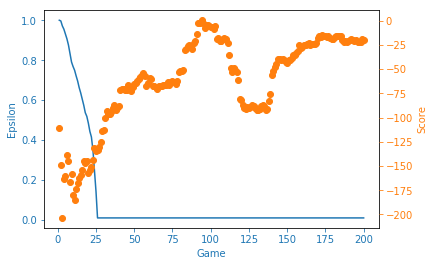

In [10]:
utils.plotLearning(x, scores, eps_history, filename)

In [ ]:


import gym

env = gym.make("BipedalWalker-v2")
env = gym.make('BipedalWalkerHardcore-v2')
env = gym.make('LunarLander-v2')
env = gym.make('CarRacing-v0')